In [9]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import umap.umap_ as umap
import cv2
from tensorflow.keras import backend as K

In [10]:
# Function to load MNIST images from idx file
def load_idx_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack('>IIII', f.read(16))  # Read metadata
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols, 1)  # Read images
    return data.astype(np.float32) / 255.0  # Normalize between 0 and 1

# Function to load MNIST labels from idx file
def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack('>II', f.read(8))  # Read metadata
        labels = np.frombuffer(f.read(), dtype=np.uint8)  # Read labels
    return labels

In [11]:
# Load train and test data
train_images = load_idx_images("train-images.idx3-ubyte")
train_labels = load_idx_labels("train-labels.idx1-ubyte")
test_images = load_idx_images("t10k-images.idx3-ubyte")
test_labels = load_idx_labels("t10k-labels.idx1-ubyte")

# Print dataset shapes
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (60000, 28, 28, 1)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28, 1)
Test Labels Shape: (10000,)


In [17]:
def residual_block(x, filters):
    skip = x  # Save input for skip connection
    
    # If input channels don't match output channels, apply a 1x1 convolution to match
    if x.shape[-1] != filters:
        skip = layers.Conv2D(filters, (1, 1), padding='same', activation=None)(skip)

    x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, skip])  # Skip connection
    x = layers.ReLU()(x)
    return x

def sampling(args):
    """Reparameterization trick to sample from a Gaussian distribution"""
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))  # Sample noise
    return z_mean + K.exp(0.5 * z_log_var) * epsilon  # Reparam trick

def build_encoder():
    input_img = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = residual_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Latent space parameters
    z_mean = layers.Dense(16, name='z_mean')(x)  # Mean of the latent distribution
    z_log_var = layers.Dense(16, name='z_log_var')(x)  # Log variance
    
    # Sampling layer using the reparameterization trick
    z = layers.Lambda(sampling, output_shape=(16,), name='z')([z_mean, z_log_var])

    return models.Model(input_img, [z_mean, z_log_var, z], name="VAE_Encoder")

def build_decoder():
    latent_input = layers.Input(shape=(16,))
    x = layers.Dense(256 * 7 * 7, activation='relu')(latent_input)
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(x)
    
    return models.Model(latent_input, x, name="VAE_Decoder")

def vae_loss(input_img, output_img, z_mean, z_log_var):
    # Reconstruction loss (binary crossentropy)
    recon_loss = tf.keras.losses.binary_crossentropy(input_img, output_img)  # No flattening needed
    recon_loss = K.sum(recon_loss, axis=[1, 2, 3])  # Sum over pixels
    recon_loss = K.mean(recon_loss)  # Average over batch
    recon_loss = K.mean(recon_loss)

    # KL divergence loss (forces latent space to be close to a normal distribution)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kl_loss = K.mean(kl_loss)

    vae.add_loss(lambda: vae_loss(input_img, reconstructed, z_mean, z_log_var))
    return recon_loss + kl_loss

# Get encoder and decoder models
encoder = build_encoder()
decoder = build_decoder()

# Connect encoder and decoder
input_img = encoder.input
z_mean, z_log_var, z = encoder(input_img)  # Get mean, log var, and sampled vector
reconstructed = decoder(z)

# Define VAE model
vae = models.Model(input_img, reconstructed, name="VAE")

# Compile with the custom loss
vae.add_loss(vae_loss(input_img, reconstructed, z_mean, z_log_var))
vae.compile(optimizer='adam')


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# Train the VAE
vae.fit(train_images, epochs=5, batch_size=32, shuffle=True)

Epoch 1/5
  39/1875 ━━━━━━━━━━━━━━━━━━━━ 2:28 81ms/step - loss: 0.4783

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


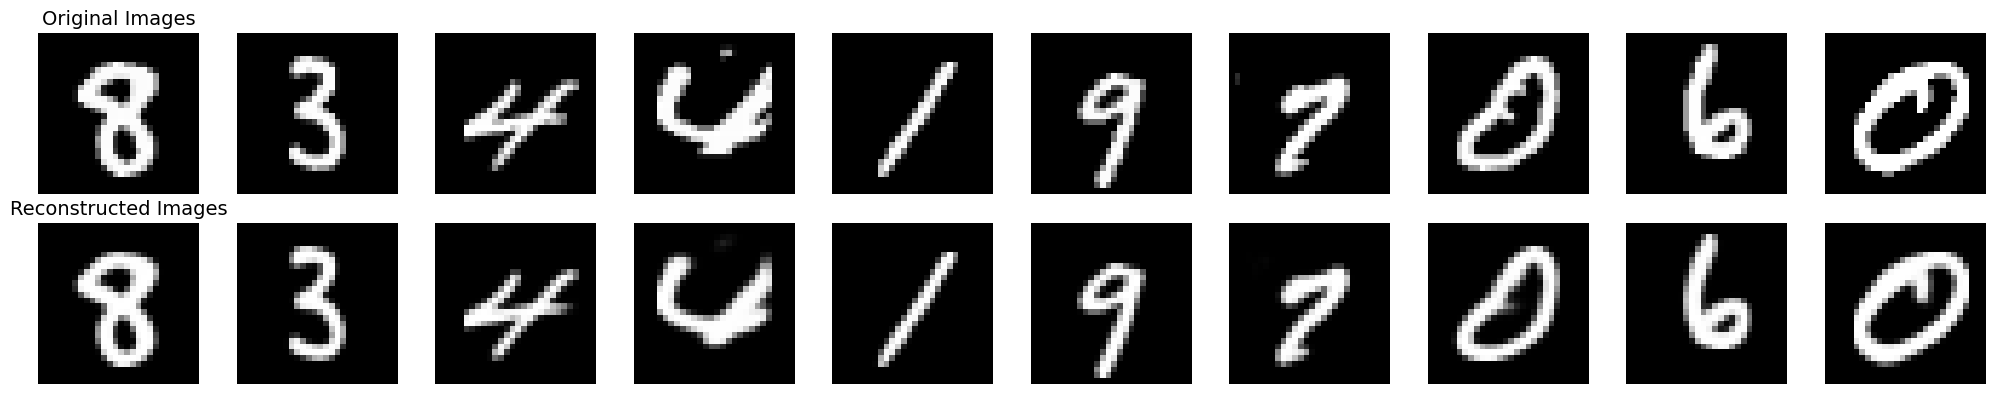

In [ ]:
# Select random images from the dataset
num_images = 10  # Number of images to display
random_indices = np.random.choice(len(train_images), num_images, replace=False)

# Encode and decode the images
encoded_imgs = encoder.predict(train_images[random_indices])  # Pass through encoder
decoded_imgs = decoder.predict(encoded_imgs)  # Pass through decoder

# Plot the images: original vs. reconstructed
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

for i in range(num_images):
    # Original images
    axes[0, i].imshow(train_images[random_indices[i]].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original Images", fontsize=14)
axes[1, 0].set_title("Reconstructed Images", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Extract Features Using Encoder
encoded_train = encoder.predict(train_images)[0]
encoded_test = encoder.predict(test_images)[0]

# Reduce to 5D using UMAP
umap_5d = umap.UMAP(n_components=8, random_state=42)
encoded_train_5d = umap_5d.fit_transform(encoded_train)
encoded_test_5d = umap_5d.transform(encoded_test)

num_clusters = 10  # Adjust based on variation in styles
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
gmm.fit(encoded_train_5d)

# Assign clusters to training and test data
train_clusters = gmm.predict(encoded_train_5d)
test_clusters = gmm.predict(encoded_test_5d)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from scipy.stats import mode

# Assign labels to clusters based on most frequent digit
def assign_labels(clusters, true_labels):
    label_map = {}
    for i in range(num_clusters):
        mask = (clusters == i)  # Select points in cluster i
        if np.sum(mask) == 0:
            label_map[i] = -1  # No samples in cluster
        else:
            most_common = mode(true_labels[mask])[0]  # Most frequent digit
            label_map[i] = most_common
    return label_map

cluster_to_label = assign_labels(train_clusters, train_labels)
predicted_labels = np.array([cluster_to_label[c] for c in test_clusters])

# Evaluate Clustering Performance
accuracy = np.mean(predicted_labels == test_labels)
print(f"GMM Classification Accuracy: {accuracy * 100:.2f}%")


GMM Classification Accuracy: 97.49%


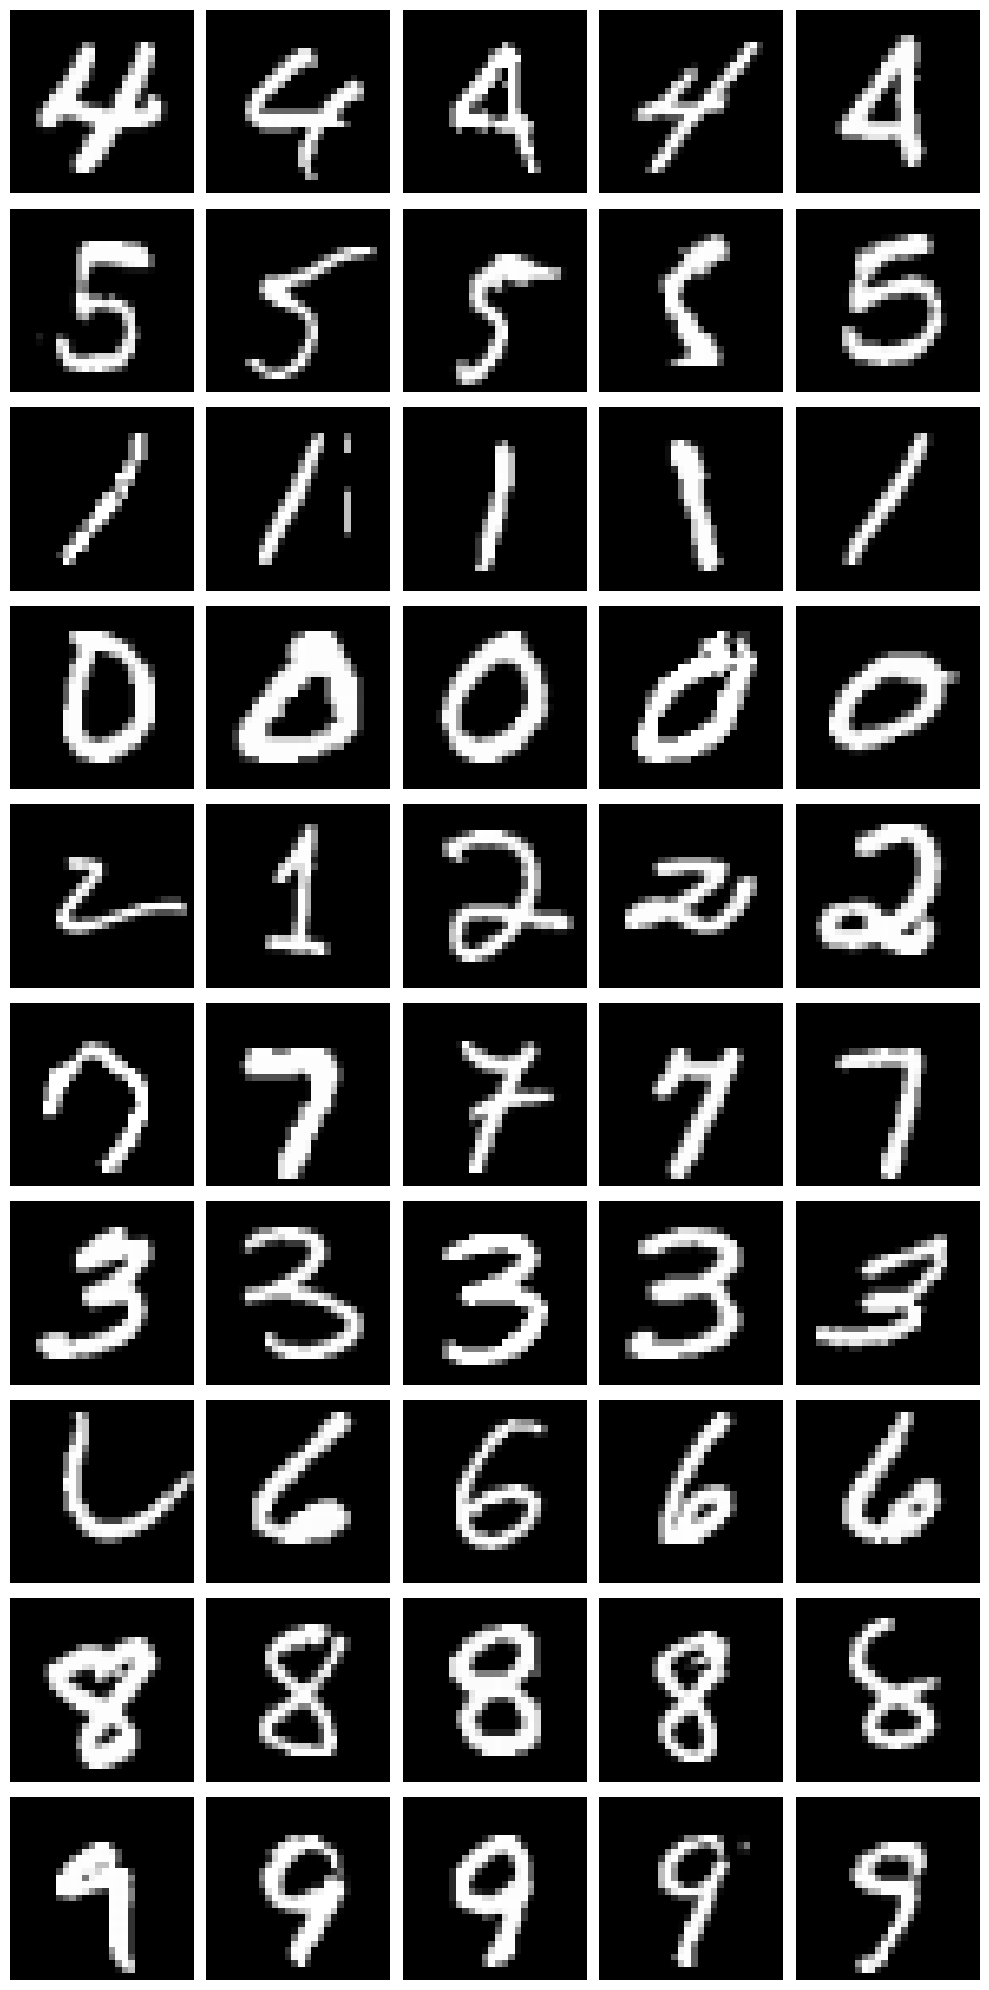

In [ ]:
# Function to plot samples from each cluster
def plot_cluster_samples(images, cluster_labels, num_samples=5):
    unique_clusters = np.unique(cluster_labels)
    fig, axes = plt.subplots(len(unique_clusters), num_samples, figsize=(num_samples * 2, len(unique_clusters) * 2))
    
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, min(num_samples, len(cluster_indices)), replace=False)
        
        for j, img_idx in enumerate(selected_indices):
            axes[i, j].imshow(images[img_idx].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display images
plot_cluster_samples(train_images, train_clusters, num_samples=5)

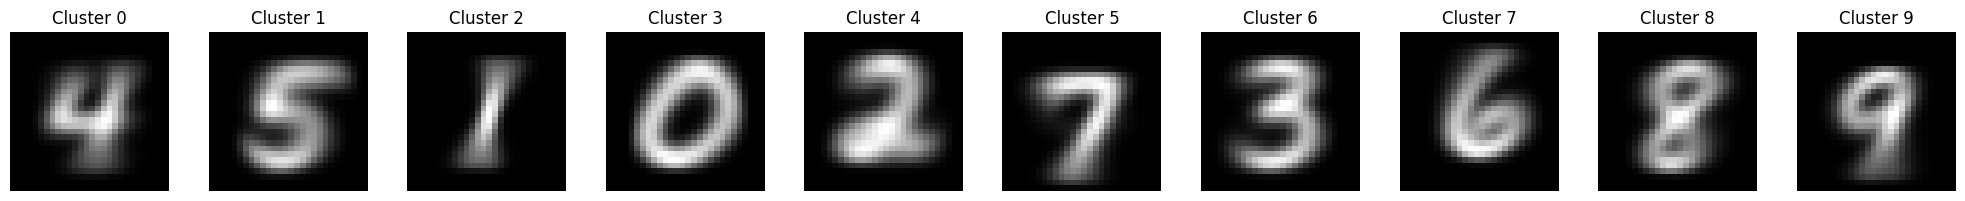

In [ ]:
def plot_average_images(images, cluster_labels, num_clusters):
    
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 2, 2))

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices for the cluster
        if len(cluster_indices) > 0:
            avg_image = np.mean(images[cluster_indices], axis=0)  # Compute mean image
        else:
            avg_image = np.zeros_like(images[0])  # Handle empty clusters

        axes[cluster].imshow(avg_image.reshape(28, 28), cmap='gray')
        axes[cluster].axis('off')
        axes[cluster].set_title(f"Cluster {cluster}")

    plt.tight_layout()
    plt.show()

# Call function to display average images from clusters
plot_average_images(train_images, train_clusters, num_clusters)

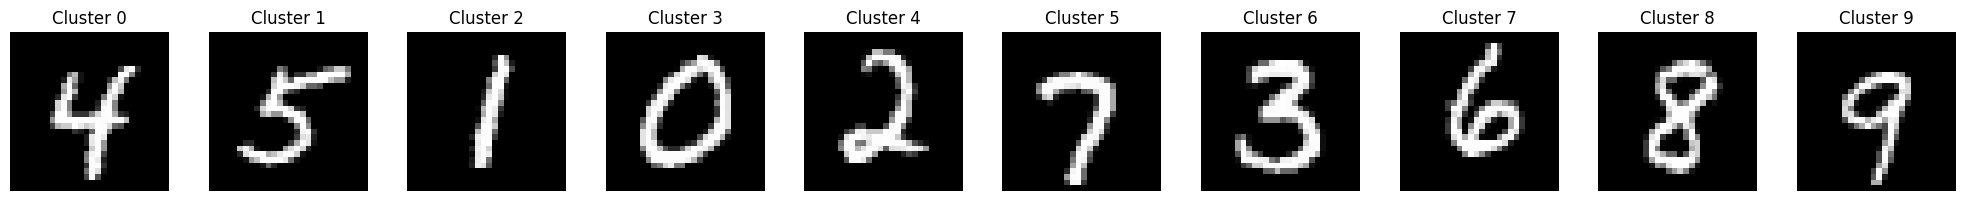

In [ ]:
from scipy.spatial.distance import cdist

def find_representative_images(encoded_images, images, cluster_labels, num_clusters):
    """
    Finds and plots the most representative image from each cluster.
    """
    representative_images = []

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices for the cluster
        if len(cluster_indices) == 0:
            representative_images.append(np.zeros_like(images[0]))  # Empty cluster placeholder
            continue

        cluster_features = encoded_images[cluster_indices]  # Get encoded features for cluster
        centroid = np.mean(cluster_features, axis=0)  # Compute centroid
        distances = cdist([centroid], cluster_features, metric="euclidean")  # Compute distances
        closest_index = cluster_indices[np.argmin(distances)]  # Find closest image index

        representative_images.append(images[closest_index])  # Store representative image

    # Plot representative images
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 2, 2))
    for i in range(num_clusters):
        axes[i].imshow(representative_images[i].reshape(28, 28), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Cluster {i}")

    plt.tight_layout()
    plt.show()

# Call function to display representative images
find_representative_images(encoded_train, train_images, train_clusters, num_clusters)

In [ ]:
num_samples_per_cluster = 20
generated_images = []

for cluster_id in range(num_clusters):
    # Sample latent vectors from a standard normal distribution
    new_latents = np.random.normal(size=(num_samples_per_cluster, 16))  # 16 is the latent space dimension

    # Decode into images
    new_images = decoder.predict(new_latents)
    generated_images.append(new_images)

generated_images = np.array(generated_images)  # Shape: (num_clusters, num_samples_per_cluster, 28, 28, 1)

fig, axes = plt.subplots(num_clusters, num_samples_per_cluster, figsize=(num_samples_per_cluster * 1.5, num_clusters * 1.5))

for i in range(num_clusters):
    for j in range(num_samples_per_cluster):
        axes[i, j].imshow(generated_images[i, j].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')

plt.suptitle("Generated Images per Cluster", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'num_clusters' is not defined

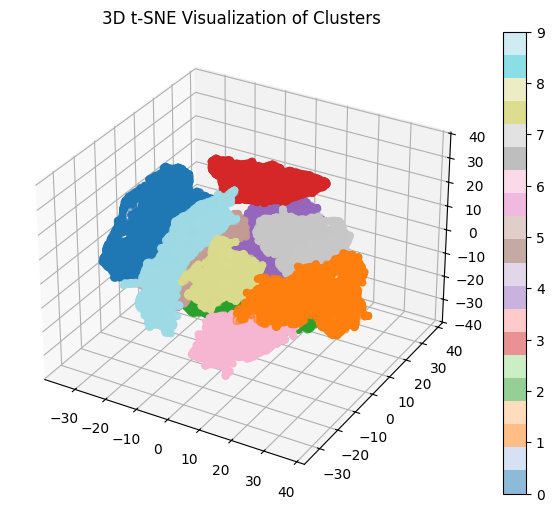

In [ ]:
# Reduce from 5D to 3D for visualization
tsne_3d = TSNE(n_components=3, random_state=42)
reduced_3d = tsne_3d.fit_transform(encoded_train_5d)

# Plot 3D scatter of clusters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_3d[:, 0], reduced_3d[:, 1], reduced_3d[:, 2], c=train_clusters, cmap='tab20', alpha=0.5)
plt.colorbar(scatter)
plt.title("3D t-SNE Visualization of Clusters")
plt.show()